# NAT Baseline

In [1]:
# !activate sak
!pip install pints numpy matplotlib pandas sklearn

from __future__ import print_function
import warnings
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [14]:
def twospirals(n_points, noise=.0, square=False, sine=False):
    """
     Returns the two spirals dataset.
    """
    n_points = int(n_points/2)
    n = np.sqrt( np.random.rand(n_points,1) ) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    d1 = (d1x, d1y)
    negd1 = (-d1x, -d1y)

    if sine: 
        sinx1, sinx2 = np.sin(d1x), np.sin(d1y)
        d1 += (sinx1, sinx2)
        negd1 += (-sinx1, -sinx2)
    if square:
        sqx1, sqx2 = d1x*d1x, d1y*d1y
        d1 += (sqx1, sqx2)
        negd1 += (-sqx1, -sqx2)

    x1 = np.hstack(d1)
    x2 = np.hstack(negd1)
    x = np.vstack( (x1, x2) )
    y = np.hstack( ( np.zeros(n_points), np.ones(n_points) ) )
    return (x, y.astype(int))

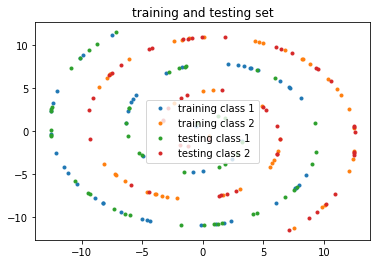

In [15]:
X_train, y_train = twospirals(n_points=100)
X_test, y_test = twospirals(n_points=100)

plt.title('training and testing set')
plt.plot(X_train[y_train==0,0], X_train[y_train==0,1], '.', label='training class 1')
plt.plot(X_train[y_train==1,0], X_train[y_train==1,1], '.', label='training class 2')
plt.plot(X_test[y_test==0,0], X_test[y_test==0,1], '.', label='testing class 1')
plt.plot(X_test[y_test==1,0], X_test[y_test==1,1], '.', label='testing class 2')
plt.legend()
plt.show()

In [4]:
param_grid = [{'activation' : ['identity', 'logistic', 'tanh', 'relu'],
                'solver' : ['lbfgs', 'sgd', 'adam'],
                'hidden_layer_sizes': [(4,), (5,), (6,), (7,), (8,)]}]

# change num_training_iter to avoid perfect models (i.e. test_acc=0, mse=0)
num_training_iter = 2

In [5]:
def test(features, X_train, X_test, y_train, y_test, neurons_to_test):
    """
    finds best ann params, bp for given features (x,y,xx,yy) and varies no. of neurons, n w/ bp
    """

    # grid search to find best params for given features
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConvergenceWarning, module='sklearn')
        gridsearch = GridSearchCV(MLPClassifier(), param_grid, cv=3, scoring='accuracy', verbose=0)
        gridsearch.fit(X_train, y_train)
        print(f'best params w/ {features} (e.g. {X_train[0]}): {gridsearch.best_params_}')

    # vary no. of neurons, n w/ best params found ^ 
    for n in neurons_to_test:
        best_activation = gridsearch.best_params_['activation']
        best_solver = gridsearch.best_params_['solver']
        clf = MLPClassifier(max_iter=num_training_iter, hidden_layer_sizes=n, activation=best_activation, solver=best_solver)
        clf.fit(X_train, y_train)
        print(f'neurons: {n[0]} \t\ttrain acc: {clf.score(X_train, y_train):.4f} \t\ttest acc: {clf.score(X_test, y_test):.4f} \t\tmse: {mean_squared_error(y_test, clf.predict(X_test)):.4f}')

In [6]:
# TEST: LINEAR FEATURES (X, Y)
X_train, y_train = twospirals(n_points=1000)
X_test, y_test = twospirals(n_points=1000)

test(features='X,Y', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, neurons_to_test=param_grid[0]['hidden_layer_sizes'])

best params w/ X,Y (e.g. [-5.14041534 -2.68894125]): {'activation': 'relu', 'hidden_layer_sizes': (6,), 'solver': 'lbfgs'}
neurons: 4 		train acc: 0.5365 		test acc: 0.5605 		mse: 0.4395
neurons: 5 		train acc: 0.4910 		test acc: 0.4480 		mse: 0.5520
neurons: 6 		train acc: 0.5430 		test acc: 0.5910 		mse: 0.4090
neurons: 7 		train acc: 0.5835 		test acc: 0.6095 		mse: 0.3905
neurons: 8 		train acc: 0.5210 		test acc: 0.5805 		mse: 0.4195


In [7]:
# TEST SINES (X, Y, sin(X), sin(Y))
X_train, y_train = twospirals(n_points=1000, sine=True)
X_test, y_test = twospirals(n_points=1000, sine=True)

test(features='X,Y,sinX,sinY', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, neurons_to_test=param_grid[0]['hidden_layer_sizes'])

best params w/ X,Y,sinX,sinY (e.g. [9.1645196  1.40910418 0.25733022 0.98695628]): {'activation': 'logistic', 'hidden_layer_sizes': (8,), 'solver': 'lbfgs'}
neurons: 4 		train acc: 0.5655 		test acc: 0.5720 		mse: 0.4280
neurons: 5 		train acc: 0.5310 		test acc: 0.5210 		mse: 0.4790
neurons: 6 		train acc: 0.5680 		test acc: 0.5660 		mse: 0.4340
neurons: 7 		train acc: 0.5775 		test acc: 0.5835 		mse: 0.4165
neurons: 8 		train acc: 0.5615 		test acc: 0.5750 		mse: 0.4250


In [8]:
# TEST SQUARES (X,Y, X*X, Y*Y)
X_train, y_train = twospirals(n_points=1000, square=True)
X_test, y_test = twospirals(n_points=1000, square=True)

test(features='X,Y,XX,YY', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, neurons_to_test=param_grid[0]['hidden_layer_sizes'])

best params w/ X,Y,XX,YY (e.g. [ -0.92081814 -11.0404523    0.84790604 121.89158701]): {'activation': 'identity', 'hidden_layer_sizes': (4,), 'solver': 'lbfgs'}
neurons: 4 		train acc: 0.9445 		test acc: 0.9460 		mse: 0.0540
neurons: 5 		train acc: 0.9990 		test acc: 0.9995 		mse: 0.0005
neurons: 6 		train acc: 0.9860 		test acc: 0.9925 		mse: 0.0075
neurons: 7 		train acc: 0.9985 		test acc: 0.9995 		mse: 0.0005
neurons: 8 		train acc: 0.9955 		test acc: 0.9985 		mse: 0.0015


In [9]:
# TEST ALL FEATURES (X,Y, sin(X), sin(Y), X*X, Y*Y) 

# generate twospirals
X_train, y_train = twospirals(n_points=1000, square=True, sine=True)
X_test, y_test = twospirals(n_points=1000, square=True, sine=True)

test(features='X,Y,sinX,sinY,XX,YY', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, neurons_to_test=param_grid[0]['hidden_layer_sizes'])

best params w/ X,Y,sinX,sinY,XX,YY (e.g. [-2.13141448  7.26218396 -0.8469266   0.82993918  4.54292768 52.73931585]): {'activation': 'identity', 'hidden_layer_sizes': (4,), 'solver': 'lbfgs'}
neurons: 4 		train acc: 0.9970 		test acc: 1.0000 		mse: 0.0000
neurons: 5 		train acc: 0.9915 		test acc: 0.9945 		mse: 0.0055
neurons: 6 		train acc: 0.9885 		test acc: 0.9920 		mse: 0.0080
neurons: 7 		train acc: 1.0000 		test acc: 1.0000 		mse: 0.0000
neurons: 8 		train acc: 0.9915 		test acc: 0.9945 		mse: 0.0055
